Hi there! 

Welcome to my notebook. This is my second notebook ever in the Kaggle platform and I choose housing price competition which is a getting started competition for beginners.
The competition is about predicting houses sale prices in Ames, Iowa with the given tabular data.

In the notebook, I try to explain functions with commands and headers also in this notebook I get 0.12687 point which means top 25% in the leaderboard.

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

# data visualization
import matplotlib.pyplot as plt 
import plotly.express as px 
import seaborn as sns 
from scipy import stats  

# Prediction models
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

#Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error 
from hyperopt import hp, tpe, fmin

In [2]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Quick Look

In [3]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

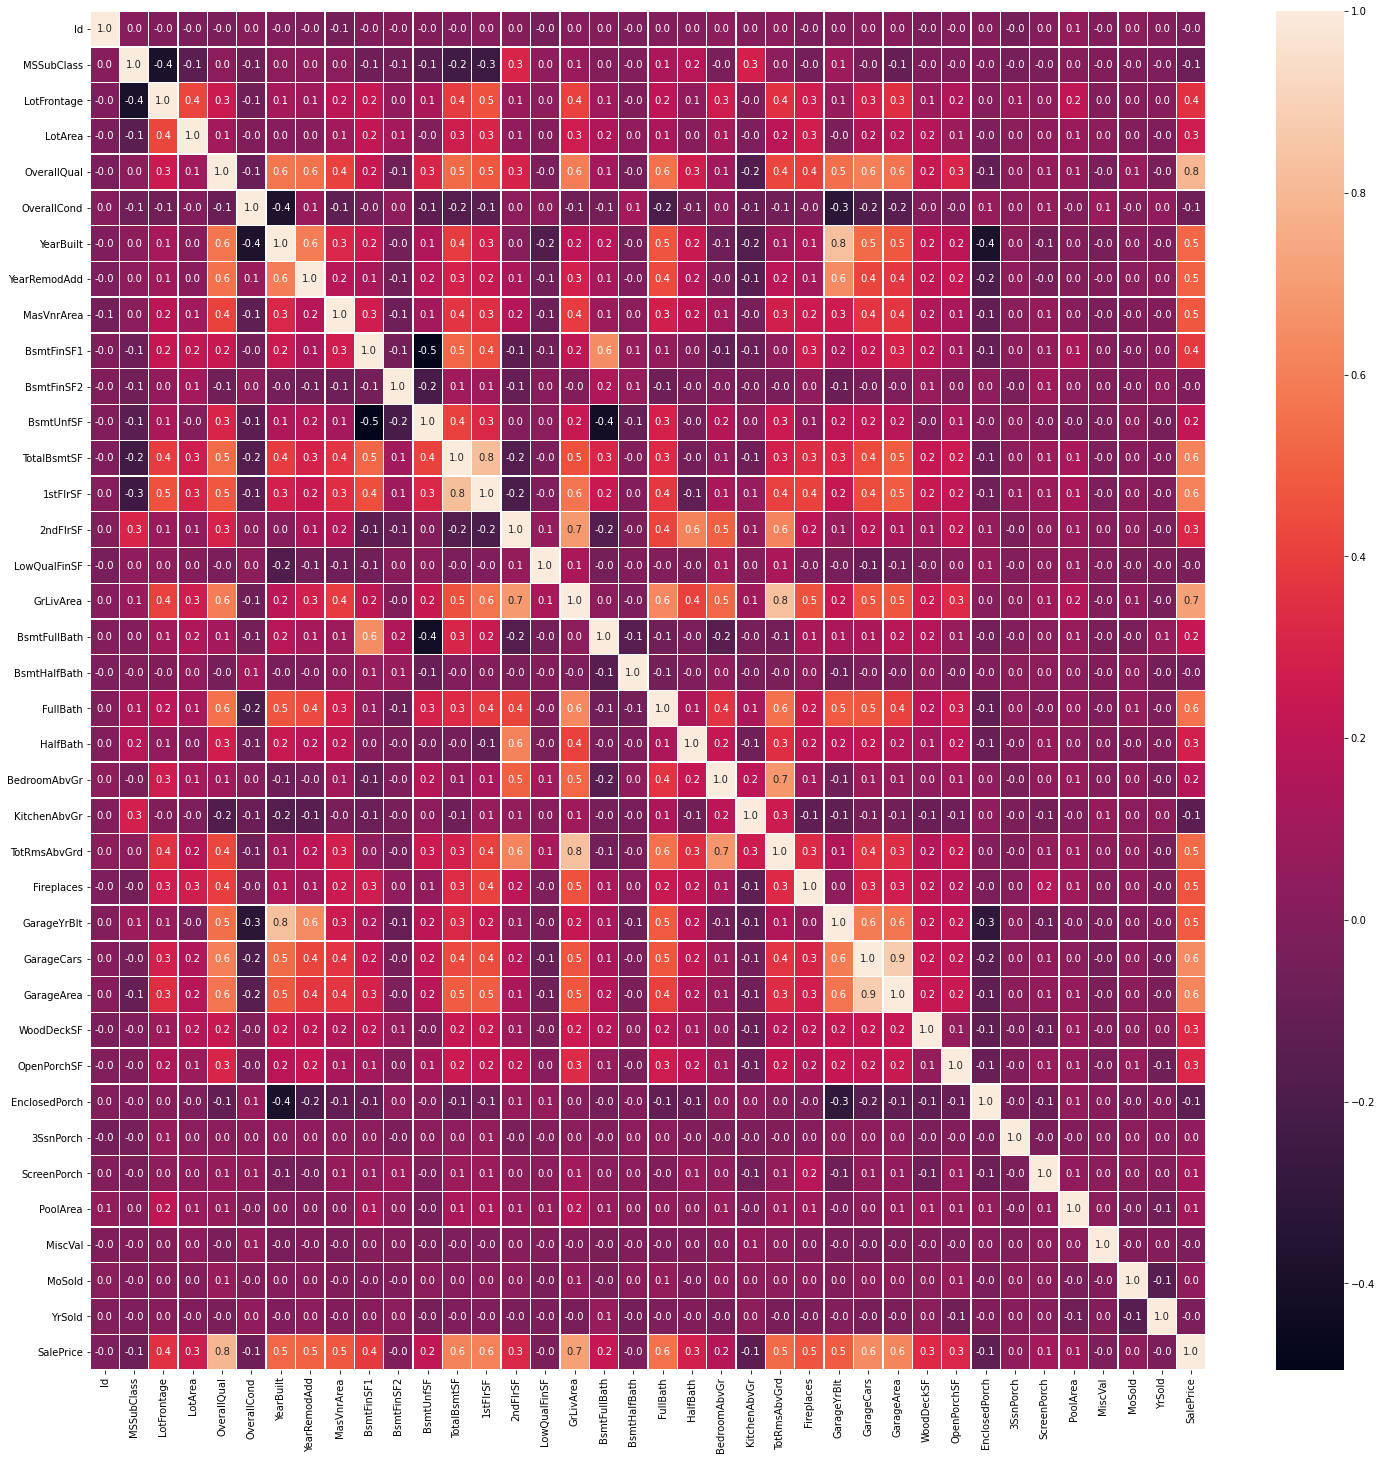

In [5]:
#correlation map
f,ax=plt.subplots(figsize=(25, 25))
sns.heatmap(train.corr(), annot=True, linewidths=.4, fmt= '.1f',ax=ax)
plt.show()

In [6]:
train.isnull().sum()[train.isnull().sum() > 100] # Features possess dramatically numerous null values that we cannot fill them properly. 

LotFrontage     259
Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

In [7]:
train.drop(["LotFrontage","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"],axis=1,inplace = True) # Dropping them

# Feature Engineering

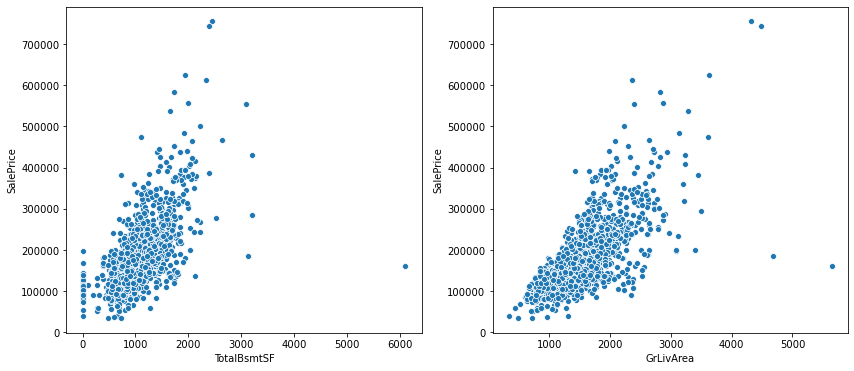

In [8]:
fig, ax =plt.subplots(1,2,figsize=(14, 6))
sns.scatterplot(x="TotalBsmtSF", y="SalePrice", data=train,ax=ax[0])
sns.scatterplot(x="GrLivArea", y="SalePrice", data=train,ax=ax[1])
fig.show()

For "TotalBsmtSF", there is an anomaly at approx. 6000 on x-axis that can fail the model. Same approach for the "GrLivArea".

For "GrLivArea", there is an anomaly at right most point that can fail the model same as "TotalBsmtSF".

So we should ignore them.

By deleting them from the data we get better correlation because the line is more linear now.

In [9]:
train = train[train.TotalBsmtSF < 5000].reset_index(drop = True)
train= train[train["GrLivArea"] < 4500].reset_index(drop = True)

In [10]:
fig_neigh = train.groupby("Neighborhood").median().sort_values(by="SalePrice")
fig = px.box(fig_neigh, x=fig_neigh.index, y="SalePrice",)
fig.show()

It is kind of linear relation so we can use it by encoding them accoring to descending median values.

In [11]:
def neig_func(model):
    dic = {'NridgHt': 25, 'NoRidge': 24, 'StoneBr': 23,
           'Timber': 22, 'Somerst': 21, 'Veenker': 20, 'Crawfor': 19,
           'ClearCr': 18, 'CollgCr': 17, 'Blmngtn': 16, 'NWAmes': 15,
           'Gilbert': 14, 'SawyerW': 13, 'Mitchel': 12, 'NPkVill': 11,
           'NAmes': 10, 'SWISU': 9, 'Blueste': 8, 'Sawyer': 7, 'BrkSide': 6,
           'Edwards': 5, 'OldTown': 4, 'BrDale': 3, 'IDOTRR': 2, 'MeadowV': 1}
    model["Neighborhood"].replace(dic,inplace = True)

In [12]:
def land_slope(model):
    # Dictionary values are created through the opposite of slope values. In other words, High value for sharp slope, Low value for flattened surface.
    
    #Gtl -> Gentle slope
    #Mod -> Moderate Slope
    #Sev -> Severe Slope
    
    dic = {"Gtl":3,"Mod":2,"Sev":1}
    model["LandSlope"].replace(dic,inplace = True)

In [13]:
train["Garage"] = train["GarageCars"] * train["GarageArea"]
corr_matrix = train.corr()
print(corr_matrix["SalePrice"].sort_values(ascending = False)[3:6])
# By creating new feature we get better correlation.

Garage         0.683392
TotalBsmtSF    0.651153
GarageCars     0.641047
Name: SalePrice, dtype: float64


In [14]:
# Function implemented to complete null values by most repeated value for each one of them.
def complete_null(model):
    for i in model.isnull().sum()[model.isnull().sum() != 0].index:
        model[i].fillna(model[i].mode()[0],inplace = True)

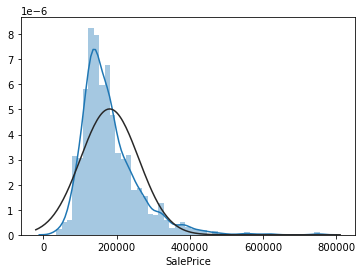

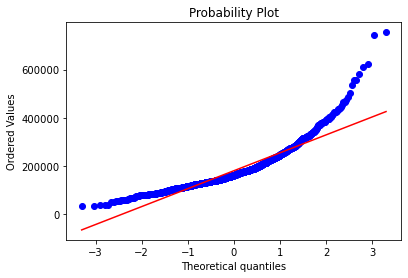

In [15]:
from scipy.stats import norm
# histogram and normal probability plot. Thanks to Pedro Marcelino for this insightful trick. I learned that the notebook created by him.
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In case of positive skewness, log transformations usually works well. It became like more the famous normal distrubition after transformation below.

In [16]:
train["SalePrice"] = np.log(train["SalePrice"])

In [17]:
def changes(model):
    model.drop(["GarageCars","Utilities","BsmtFinSF2","BsmtUnfSF"],axis=1,inplace = True) # No need them
    
    # Used the functions implemented above
    land_slope(model) 
    neig_func(model)
    
    # To get better correlation, I segmented the data with slightly better values.
    model["YearBuilt"] = pd.cut(model["YearBuilt"],bins=[1870,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,1995,2000,2003,2005,2007,2011],labels =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).astype(int)
    
    # Categorical features to numerical features
    model["Foundation"].replace({"PConc":6,"Stone":5,"CBlock":4,"Wood":3,"BrkTil":2,"Slab":1},inplace = True)
    model.replace({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},inplace = True)
    model["CentralAir"].replace({"Y":1,"N":0},inplace = True)
    
    # Some ineffable feature engineering 
    model["FirstandSecondSum"] = model["2ndFlrSF"] + model["1stFlrSF"]
    model["Qual"] = model["KitchenQual"] + model["ExterQual"]
    model["NeigYear"] = model["Neighborhood"] + model["YearBuilt"]
    model["AllQual"] = model["OverallQual"] * model["Qual"]
    model["hadi"] = model["FirstandSecondSum"] + model["TotalBsmtSF"] # "hadi" means "come on" in Turkish. I created this feature hopefully when I was stucked in generating new feautes.
    
    # Log transformation same like we did for "SalePrice"
    model["GrLivArea"] = np.log(model["GrLivArea"])
    model["LotArea"] = np.log(model["LotArea"])
    model['hadi'] = np.log(model['hadi'])
    
    # Another anomaly detection
    model = model[model["LotArea"] < 100000].reset_index(drop=True)
    
    # Some brand new features after I reach top 40%.
    model = model.assign(HasFirePlace = (model["Fireplaces"] != 0).astype(int))
    model = model.assign(HasGarageArea = (model["GarageArea"] != 0).astype(int))
    model = model.assign(HasOpenPorchSF = (model["OpenPorchSF"] != 0).astype(int))
    model = model.assign(HasPoolArea = (model["PoolArea"] != 0).astype(int))
    model = model.assign(HasMasVnrArea = (model["MasVnrArea"] != 0).astype(int))  
    
    model.drop(["KitchenQual","OverallQual","Qual","Fireplaces","OpenPorchSF","FirstandSecondSum","TotalBsmtSF","ExterQual","GarageArea","2ndFlrSF","1stFlrSF","YearRemodAdd","PoolArea"],axis=1,inplace = True)

    return model
train = changes(train)

In [18]:
train["BsmtQual"].fillna(train.BsmtQual.median(),inplace = True)
train["MasVnrArea"].fillna(train.MasVnrArea.median(),inplace = True)
train["BsmtCond"].fillna(3,inplace=True)
complete_null(train)
train = pd.get_dummies(train)

In [19]:
print("Train Data has {} rows".format(train.shape[0]))
print("Train Data has {} columns".format(train.shape[1]))
print(f"Train Data memory usage is {train.memory_usage().sum() / 1024 ** 2:.3f} MB")

Train Data has 1458 rows
Train Data has 203 columns
Train Data memory usage is 0.711 MB


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 203 entries, Id to SaleCondition_Partial
dtypes: float64(10), int64(34), uint8(159)
memory usage: 727.7 KB


To get lower memory usage you can transform data types to int8 or somethings like that but in this notebook I don't do that because memory is not a big deal in this notebook.

In [21]:
corr_matrix = train.corr()
corr_matrix["SalePrice"].sort_values(ascending = False)[:20]

SalePrice           1.000000
AllQual             0.828666
hadi                0.817796
NeigYear            0.747133
Neighborhood        0.740221
GrLivArea           0.737427
Garage              0.674725
BsmtQual            0.615118
YearBuilt           0.613820
FullBath            0.595899
TotRmsAbvGrd        0.537702
Foundation          0.532903
HasFirePlace        0.510253
HeatingQC           0.473938
HasOpenPorchSF      0.449388
BsmtFinType1_GLQ    0.441363
MasVnrArea          0.430569
GarageFinish_Fin    0.419611
GarageYrBlt         0.406247
LotArea             0.402814
Name: SalePrice, dtype: float64

# Prediction

In [22]:
# Take a look on how it works with some powerful models
def predict_func(df):
    X = df.drop("SalePrice",axis=1)
    y = df.loc[:,"SalePrice"]
    
    ran_for_reg = RandomForestRegressor()
    scores_rand = cross_val_score(ran_for_reg, X, y, cv=15,scoring="neg_root_mean_squared_error")
    print("Random Forest Regressor: " + str(-scores_rand.mean()))
    
    grad_boost_reg = GradientBoostingRegressor()
    scores_grad = cross_val_score(grad_boost_reg, X, y, cv=15,scoring="neg_root_mean_squared_error")
    print("Gradient Boost Regression: " + str(-scores_grad.mean()))
    
    xg_boost_reg = xgb.XGBRegressor()
    scores_xg = cross_val_score(xg_boost_reg, X, y, cv=15,scoring="neg_root_mean_squared_error")
    print("XG Boost Regression: " + str(-scores_xg.mean()))

In [23]:
predict_func(train.drop("Id",axis=1)) # We do not need Id column deeply

Random Forest Regressor: 0.12928466179797882
Gradient Boost Regression: 0.11985388690886688
XG Boost Regression: 0.127436289781047


I think not bad at all so let's seperate our final data before using optimizer for xgboost

In [24]:
X_train = train.drop(["SalePrice","Id"],axis=1)
y_train = train.loc[:,"SalePrice"]

Let's apply the same changes to test data

In [25]:
def test_changes(model):
    model["GarageCars"].fillna(model.GarageCars.median(),inplace = True)
    model["GarageArea"].fillna(model.GarageArea.mean(),inplace = True)
    model["Garage"] = model["GarageCars"] * model["GarageArea"]
    model.drop(["GarageCars","LotFrontage","Alley","FireplaceQu","PoolQC","Fence","MiscFeature","Utilities","BsmtFinSF2","BsmtUnfSF"],axis=1,inplace = True)
    land_slope(model)
    neig_func(model)
    model["YearBuilt"] = pd.cut(model["YearBuilt"],bins=[1870,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,1995,2000,2003,2005,2007,2011],labels =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]).astype(int)
    model["Foundation"].replace({"PConc":6,"Stone":5,"CBlock":4,"Wood":3,"BrkTil":2,"Slab":1},inplace = True)
    model.replace({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1},inplace = True)
    model["CentralAir"].replace({"Y":1,"N":0},inplace = True)
    model["FirstandSecondSum"] = model["2ndFlrSF"] + model["1stFlrSF"]
    model["KitchenQual"].fillna(model.KitchenQual.median(),inplace = True)
    model["ExterQual"].fillna(model.ExterQual.median(),inplace = True)
    model["Qual"] = model["KitchenQual"] + model["ExterQual"]
    model["NeigYear"] = model["Neighborhood"] + model["YearBuilt"]
    
    model["AllQual"] = model["OverallQual"] * model["Qual"]
    model["hadi"] = model["FirstandSecondSum"] + model["TotalBsmtSF"]
    model["GrLivArea"] = np.log(model["GrLivArea"])
    model["LotArea"] = np.log(model["LotArea"])
    model['hadi'] = np.log(model['hadi'])
    model = model.assign(HasFirePlace = (model["Fireplaces"] != 0).astype(int))
    model = model.assign(HasGarageArea = (model["GarageArea"] != 0).astype(int))
    model = model.assign(HasOpenPorchSF = (model["OpenPorchSF"] != 0).astype(int))
    model = model.assign(HasPoolArea = (model["PoolArea"] != 0).astype(int))
    model = model.assign(HasMasVnrArea = (model["MasVnrArea"] != 0).astype(int))
    model.drop(["KitchenQual","OverallQual","Qual","Fireplaces","OpenPorchSF","FirstandSecondSum","TotalBsmtSF","ExterQual","GarageArea","2ndFlrSF","1stFlrSF","YearRemodAdd","PoolArea"],axis=1,inplace = True)
    return model
test = test_changes(test)
test["BsmtQual"].fillna(test.BsmtQual.median(),inplace = True)
test["MasVnrArea"].fillna(test.MasVnrArea.median(),inplace = True)
test["hadi"].fillna(test.hadi.median(),inplace = True)
complete_null(test)
test = pd.get_dummies(test)
X_test = test.drop("Id",axis=1)

In [26]:
print("Test Data has {} rows".format(test.shape[0]))
print("Test Data has {} columns".format(test.shape[1]))
print(f"Test Data memory usage is {test.memory_usage().sum() / 1024 ** 2:.3f} MB")

Test Data has 1459 rows
Test Data has 189 columns
Test Data memory usage is 0.682 MB


Hey look at the number of columns ! 

Unfortunately, both of data do not contain exactly same column but we can get them like we want to use

In [27]:
for i in X_train.columns:   
    if not i in X_test:
        print(i)

Condition2_RRAe
Condition2_RRAn
Condition2_RRNn
HouseStyle_2.5Fin
RoofMatl_Membran
RoofMatl_Metal
RoofMatl_Roll
Exterior1st_ImStucc
Exterior1st_Stone
Exterior2nd_Other
Heating_Floor
Heating_OthW
Electrical_Mix


These are the columns in train but not in test. Therefore, if we get rid of them, then it will be just OK.

In [28]:
not_in = ['Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_Other',
 'Heating_Floor',
 'Heating_OthW',
 'Electrical_Mix']

X_train.drop(not_in,axis=1,inplace=True)

In [29]:
predict_func(train.drop("Id",axis=1))

Random Forest Regressor: 0.12872667187571443
Gradient Boost Regression: 0.12048909451866963
XG Boost Regression: 0.127436289781047


I think we did not lose anything by deleting them because errors look almost same with the errors before deleting them

In [30]:
# Parameters we are about to use for trying to get best result for xgboosting. I decide to use xgboosting because it works well better than any other regression models. I try all of the models and conclude with xgboosting.
space = {'n_estimators':hp.quniform('n_estimators', 1000, 4000, 100),
         'gamma':hp.uniform('gamma', 0.01, 0.05),
         'learning_rate':hp.uniform('learning_rate', 0.00001, 0.025),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.98),
         'colsample_bylevel':hp.uniform('colsample_bylevel', 0.60, 0.98),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'gamma': params['gamma'],
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'colsample_bylevel': params['colsample_bylevel'],
             'reg_lambda': params['reg_lambda']}
    
    xb_a= xgb.XGBRegressor(**params)
    score = cross_val_score(xb_a, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return -score

In [31]:
best = fmin(fn= objective, space= space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 20/20 [15:25<00:00, 46.29s/trial, best loss: 0.013119462820944292]


In [32]:
xb_b = xgb.XGBRegressor(random_state=0,
                        n_estimators=int(best['n_estimators']), 
                        colsample_bytree= best['colsample_bytree'],
                        gamma= best['gamma'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        colsample_bylevel= best['colsample_bylevel'],
                        reg_lambda= best['reg_lambda']
                       )

xb_b.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.012334455088591312, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=2.1713829044702413, scale_pos_weight=1,
             subsample=0.8459257473555255, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
mean_squared_error(y_train,xb_b.predict(X_train))

0.005208583913761141

In [34]:
FirstTest = xb_b.predict(X_test)
FirstTest = FirstTest.reshape(-1,1)

As you remember we applied log transformasion to SalePrice so the model did the job by looking at transformed data but kaggle does not accept results like that so we need to transform SalePrice back with np.exp because it is reverse of np.log

In [35]:
FirstTest = np.exp(FirstTest) 
result = pd.DataFrame(data = test["Id"])
result["SalePrice"]= FirstTest
result.to_csv(r'xgboost_result.csv',index = False, header=True)

I am glad for any comment or suggestion also do not hesitate to ask any kind of questions.